In [1]:
%matplotlib inline

from __future__ import division
import igraph as ig
from datetime import datetime, timedelta
import itertools
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.colors
import os
import csv
import random
import glob
import re
import time
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter, HourLocator, DayLocator
import matplotlib.ticker as ticker
import random
import json
import cPickle as pickle
import cairo
from collections import defaultdict
import pyqt_fit.nonparam_regression as smooth
from pyqt_fit import npr_methods
import pyqt_fit.bootstrap as bs
from _pybgpstream import BGPStream, BGPRecord, BGPElem
from IPython.display import display
import sys
import fnmatch
import urllib, urllib2
from lxml import etree
from multiprocessing import Pool, cpu_count
import csv
import json
from urllib import urlencode, urlopen
from os import mkdir
from shutil import rmtree
import ijson
import bigjson
import sqlite3
import scipy.stats as stats
import calendar

# Announcement analysis

## Reading the json file

In [2]:
start = time.time()

os.chdir("/your_directory_path/data/")

with open('interevent_time_dic_Indonesia_a.json', 'rb') as fp:
    count_table = json.load(fp)
    
print 'time loading:', time.time() - start

time loading: 829.728408813


In [3]:
count_table.keys()

[u'route-views.saopaulo',
 u'route-views.perth',
 u'route-views.isc',
 u'route-views.wide',
 u'route-views.soxrs',
 u'route-views.jinx',
 u'route-views.nwax',
 u'route-views.telxatl',
 u'route-views.eqix',
 u'route-views.kixp',
 u'route-views3',
 u'route-views.sydney',
 u'route-views.linx',
 u'route-views6',
 u'route-views2',
 u'route-views4']

## Compute burstiness

In [6]:
def compute_burstiness(inter_event_times_list):
    
    time_array = np.array(inter_event_times_list)
    seconds_array = np.array([(time_array[index] - time_array[index-1]) for index in range(1, len(time_array))])
    
    mu = np.mean(seconds_array)
    sigma = np.std(seconds_array)
    
    return (sigma - mu)/(sigma + mu)

def compute_burstiness_modified(inter_event_times_list):
    
    time_array = np.array(inter_event_times_list)
    seconds_array = np.array([(time_array[index] - time_array[index-1]) for index in range(1, len(time_array))])
    
    mu = np.mean(seconds_array)
    sigma = np.std(seconds_array)
    
    n = len(seconds_array)
    b = (sigma - mu)/(sigma + mu)
    
    numerator = (n + 1)**0.5 - (n - 1)**0.5 + ((n + 1)**0.5 + (n - 1)**0.5)*b
    denominator = (n + 1)**0.5 + (n - 1)**0.5 - 2 + ((n + 1)**0.5 - (n - 1)**0.5 - 2)*b
    
    return numerator/denominator

date_reference_low = '2014-04-02 06:00:00'
date_reference_hight = '2014-04-03 06:00:00'

timestamp_low = calendar.timegm(datetime.strptime(date_reference_low, '%Y-%m-%d %H:%M:%S').utctimetuple())
timestamp_hight = calendar.timegm(datetime.strptime(date_reference_hight, '%Y-%m-%d %H:%M:%S').utctimetuple())

print int((datetime.strptime(date_reference_low, '%Y-%m-%d %H:%M:%S') - datetime.utcfromtimestamp(0)).total_seconds()), int((datetime.strptime(date_reference_hight, '%Y-%m-%d %H:%M:%S') - datetime.utcfromtimestamp(0)).total_seconds())

print timestamp_low, timestamp_hight

1396418400 1396504800
1396418400 1396504800


# Compute joint distribution for the attacker

In [7]:
asn_attacker = '4761'

bivarite_distribution_dic = defaultdict(list)
burstiness_annoucement_dic = defaultdict(lambda: defaultdict(list))
# hijacker_dic = defaultdict(int)
    
for collector in count_table:
    
    total = len(count_table[collector])
    print collector, total
    
    count = 0
    for asn in count_table[collector]:
        
        # Check for communities
        if '{' not in asn:
        
            if asn == asn_attacker:
                print 'included'

            # Get a list of inter_arrival_times with no duplicates
            inter_arrival_times = list(set(count_table[collector][asn]))

            # Get a filtered list of interarrival times
            inter_arrival_times_filtered = [event_time for event_time in inter_arrival_times if timestamp_low <= event_time <= timestamp_hight]

            # Consider only ases with more than 100 events
            if len(inter_arrival_times_filtered) >= 5:

                # Compute burtiness
                # burstiness = compute_burstiness(sorted(inter_arrival_times_filtered))
                burstiness = compute_burstiness_modified(sorted(inter_arrival_times_filtered))

                # Remove duplicates
                # volume = len(set(count_table[collector][asn]))
                volume = len(inter_arrival_times_filtered)

                # Compute the number of every possible as
                burstiness_annoucement_dic[collector][asn] = [burstiness, volume]

                if asn == asn_attacker:
                    print 'burstiness', burstiness, volume

                bivarite_distribution_dic[collector].append([burstiness, volume])

                count += 1
    # break
            
    print count, 100*(count/total), '\n'

route-views.saopaulo 47082
included
burstiness 0.969458342421 12724
31271 66.4181640542 

route-views.perth 746
59 7.90884718499 

route-views.isc 47087
included
burstiness 0.96773671433 12064
15710 33.3637734407 

route-views.wide 20267
included
burstiness 0.714043760687 2927
4068 20.0720382888 

route-views.soxrs 6998
included
burstiness 0.403765428855 30
293 4.18691054587 

route-views.jinx 27749
included
burstiness 0.605371778937 671
2741 9.87783343544 

route-views.nwax 47006
included
burstiness 0.971982764468 7028
7974 16.9637918564 

route-views.telxatl 37224
included
burstiness 0.963362002583 6929
8548 22.9636793467 

route-views.eqix 47051
included
burstiness 0.963664221406 10938
31624 67.2121740239 

route-views.kixp 129
32 24.8062015504 

route-views3 46930
included
burstiness 0.960245203786 9617
19244 41.0057532495 

route-views.sydney 47066
included
burstiness 0.950633732962 3595
10379 22.0520120682 

route-views.linx 47181
included
burstiness 0.953492360415 12918
46510 98

## Box plot Burstiness

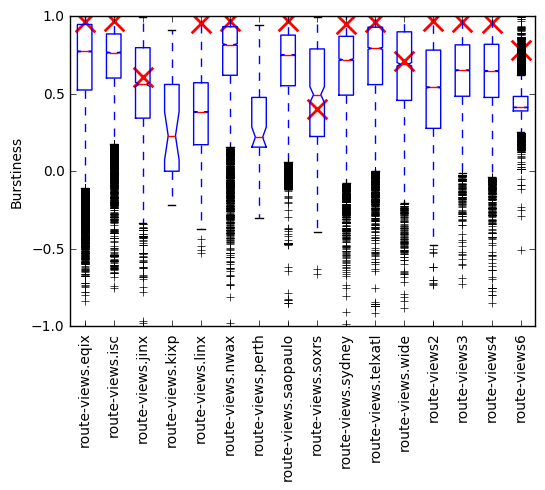

In [8]:
asn_attacker = '4761'

fig, ax = plt.subplots()

data = []
for collector in sorted(count_table):
    # print collector
    burstiness_array = np.array(bivarite_distribution_dic[collector])[:,0]
    burstiness_array = burstiness_array[np.isfinite(burstiness_array)]
    data.append(burstiness_array)

ax.boxplot(data, notch=True, labels=sorted(count_table.keys()))   
ax.set_ylim([-1, 1])

collector_number = 1

for collector in sorted(count_table):
    if len(burstiness_annoucement_dic[collector][asn_attacker])>0:
        ax.scatter(collector_number, burstiness_annoucement_dic[collector][asn_attacker][0], marker="x", c="red", s=200, lw=2)
    # else:
        # ax.scatter(collector_number, hijacker_dic[collector], marker="x", c="red", s=200, lw=2)
    collector_number += 1

ax.set_ylabel("Burstiness", labelpad=5)

plt.xticks(rotation=90)
plt.show()

In [9]:
# To save the ases with highest burstiness
dic_of_tops_burstiness = defaultdict(list) 

for collector in sorted(burstiness_annoucement_dic):
    print collector
    
    temp_dic = {}
    
    for asn in burstiness_annoucement_dic[collector]:
        # Check if it is possible to compute
        if len(burstiness_annoucement_dic[collector][asn]) > 0:
            # burstiness
            temp_dic[asn] = burstiness_annoucement_dic[collector][asn][0]
            
    tops_asn = sorted(temp_dic.items(), key=lambda (k, v): v, reverse=True)[0:10]
    print tops_asn
    
    for top_asn in tops_asn[:5]:
        # print top_asn[0], type(top_asn[0])
        if '{' not in top_asn[0]:
            dic_of_tops_burstiness[collector].append(top_asn[0])
        else:
            candidates = top_asn[0][1:] 
            candidates = candidates[:-1]
            # print top_asn[0], candidates, candidates.split(',')
            dic_of_tops_burstiness[collector].append(candidates.split(',')[0])
    
    # print sorted(burstiness_annoucement_dic[collector].items(), key=lambda (k, v): v, reverse=True)[0:10]
    # break

print 'top_5'
print dic_of_tops_burstiness

route-views.eqix
[(u'40270', 0.99979160417762425), (u'27160', 0.9997827666721717), (u'10241', 0.99973932619467309), (u'23165', 0.99973886166302917), (u'12171', 0.99973885112617034), (u'46695', 0.99969588935351594), (u'27283', 0.99969586443320502), (u'13558', 0.99969560738595398), (u'22088', 0.99965355827465852), (u'15342', 0.99964906748906057)]
route-views.isc
[(u'198568', 0.99978347536425038), (u'24051', 0.99961373128335829), (u'42116', 0.99960953025584476), (u'55816', 0.99959698070723435), (u'18173', 0.99959698031337441), (u'45195', 0.99957576381340851), (u'64519', 0.99952443901448729), (u'51272', 0.99949910573714418), (u'58617', 0.99948785410662788), (u'25408', 0.99946586793898351)]
route-views.jinx
[(u'48944', 0.99717489455709107), (u'28885', 0.99717489455709107), (u'5484', 0.99717489455709107), (u'48861', 0.99640177566290289), (u'263174', 0.99631609568424073), (u'23126', 0.99607555306576179), (u'11426', 0.99601050976919892), (u'9259', 0.99590596062276615), (u'43733', 0.99520191124

# Box plot announcements

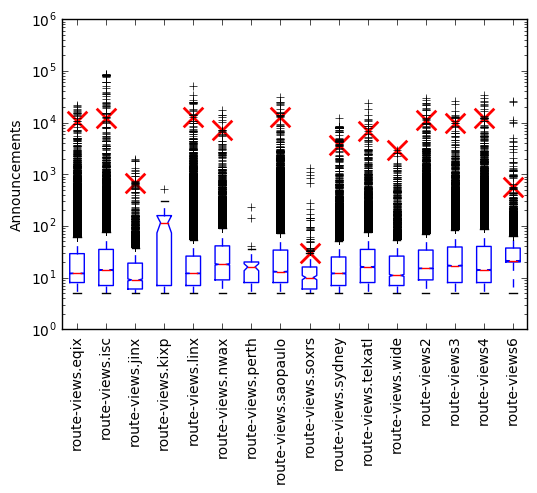

In [10]:
asn_attacker = '4761'

fig, ax = plt.subplots()

data = []
for collector in sorted(count_table):
    # print collector
    data.append(np.array(bivarite_distribution_dic[collector])[:,1])

ax.boxplot(data, notch=True, labels=sorted(count_table.keys()))   
ax.set_yscale("log")
ax.set_ylim([10**0, 10**6])

collector_number = 1

for collector in sorted(count_table):
    if len(burstiness_annoucement_dic[collector][asn_attacker])>0:
        ax.scatter(collector_number, burstiness_annoucement_dic[collector][asn_attacker][1], marker="x", c="red", s=200, lw=2)
    # else:
        # ax.scatter(collector_number, hijacker_dic[collector], marker="x", c="red", s=200, lw=2)
    collector_number += 1

ax.set_ylabel("Announcements", labelpad=5)

plt.xticks(rotation=90)
plt.show()

In [11]:
for collector in sorted(burstiness_annoucement_dic):
    print collector
    
    temp_dic = {}
    
    for asn in burstiness_annoucement_dic[collector]:
        # Check if it is possible to compute
        if len(burstiness_annoucement_dic[collector][asn]) > 0:
            # announcements
            temp_dic[asn] = burstiness_annoucement_dic[collector][asn][1]
    
    print sorted(temp_dic.items(), key=lambda (k, v): v, reverse=True)[0:10]

route-views.eqix
[(u'54465', 21703), (u'22561', 21173), (u'668', 20414), (u'36947', 18174), (u'13118', 17382), (u'5978', 16450), (u'41691', 16162), (u'40009', 15634), (u'17557', 15080), (u'53062', 14977)]
route-views.isc
[(u'7643', 85376), (u'55475', 85234), (u'45786', 84776), (u'24206', 84398), (u'55334', 84095), (u'55781', 84035), (u'17941', 83975), (u'38235', 83972), (u'24284', 83961), (u'131454', 83700)]
route-views.jinx
[(u'13118', 1936), (u'17072', 1874), (u'17557', 1781), (u'41691', 1773), (u'36947', 1300), (u'11054', 1184), (u'35104', 1131), (u'53062', 1070), (u'8402', 1045), (u'6629', 920)]
route-views.kixp
[(u'9129', 521), (u'36914', 309), (u'36977', 192), (u'37075', 179), (u'37109', 170), (u'21491', 165), (u'37376', 163), (u'29039', 158), (u'37063', 158), (u'65000', 157)]
route-views.linx
[(u'200120', 51937), (u'36947', 33865), (u'668', 27127), (u'54465', 25335), (u'17072', 25192), (u'17557', 25184), (u'53062', 24928), (u'41691', 24230), (u'13118', 24122), (u'40009', 24100)]

## Both burstiness and announcements

In [12]:
for collector in sorted(burstiness_annoucement_dic):

    print collector

    temp_dic = {}

    for asn in burstiness_annoucement_dic[collector]:
        # Check if it is possible to compute
        if len(burstiness_annoucement_dic[collector][asn]) > 0:
            # burstiness
            temp_dic[asn] = burstiness_annoucement_dic[collector][asn]

    percentile_burstiness = np.percentile(np.array(temp_dic.values())[:,0], 99.75) #99.75, 99.0
    percentile_announcements = np.percentile(np.array(temp_dic.values())[:,1], 99.75)
    print percentile_burstiness, percentile_announcements

    # print burstiness_annoucement_dic[collector].items()

    filtered_dic = {key:value for (key, value) in burstiness_annoucement_dic[collector].items() if (len(value) == 2 and value[0] >= percentile_burstiness and value[1] >= percentile_announcements)}
    print len(filtered_dic), filtered_dic
    # break
    # print sorted(temp_dic.items(), key=lambda (k, v): v, reverse=True)[0:10]

route-views.eqix
0.999390514931 2045.8275
0 {}
route-views.isc
0.999113775657 81796.185
0 {}
route-views.jinx
0.995921642995 1079.15
0 {}
route-views.kixp
0.893298548683 504.57
0 {}
route-views.linx
0.898250690442 1883.005
18 {u'132045': [0.92778434309404545, 6483], u'3382': [0.90031309690250716, 1896], u'7629': [0.95522020648362527, 3105], u'45786': [0.92888425645814576, 2698], u'4750': [0.9209654164820873, 2075], u'38515': [0.90481823417460583, 2327], u'8844': [0.95693042346166846, 4451], u'10139': [0.90100553792637583, 2549], u'6102': [0.92541383911102848, 2889], u'4761': [0.95349236041474883, 12918], u'4651': [0.94220568167579943, 2124], u'45727': [0.90729084650224678, 3042], u'31195': [0.92316031984271885, 2444], u'37447': [0.94669611160127298, 2225], u'55666': [0.90803606216734767, 2660], u'376': [0.90989283915002384, 4405], u'27820': [0.91707467832805523, 3072], u'9497': [0.94722247072435961, 2065]}
route-views.nwax
0.998811073986 3357.9425
0 {}
route-views.perth
0.912146572773 

## Rank collectors by Routers

In [18]:
# Load the dictionary of knowledge
with open("dic_feeders_evolution_Indonesia.p", "rb") as fp:
    evolution_dic = pickle.load(fp)


reference_time = "2014-03-31 00:00:00"
new_dic = {}

for collector in evolution_dic:
    new_dic[collector] = len(set(np.array(evolution_dic[collector][reference_time])[:,1])) # ASes are index 1
    
number_of_feeders = sorted(new_dic, key=lambda k: new_dic[k], reverse=True) # Sort collectors in increasing order
number_of_feeders = ['route-views' + feed if (feed == '2' or feed == '3' or feed == '4' or feed == '6') else 'route-views.' + feed for feed in number_of_feeders]
# number_of_feeders.reverse()
print number_of_feeders

['route-views.linx', 'route-views.saopaulo', 'route-views4', 'route-views2', 'route-views.eqix', 'route-views6', 'route-views.isc', 'route-views3', 'route-views.sydney', 'route-views.jinx', 'route-views.telxatl', 'route-views.nwax', 'route-views.wide', 'route-views.perth', 'route-views.kixp', 'route-views.soxrs']


## Get the four more significant

route-views.linx
percentile_x 0.769487466529
percentile_y 140.0
[0.95349236041474883, 12918]
61291 [0.99947269448953269, 27]
61901 [0.99905913442791949, 13]
133085 [0.99673766392526164, 19]
route-views.saopaulo
percentile_x 0.96002100707
percentile_y 210.0
[0.96945834242058315, 12724]
61291 [0.99904320696985272, 45]
50139 [0.99824640210933202, 15]
23041 [0.99671300893307724, 32]
route-views4
percentile_x 0.985864127323
percentile_y 240.0
[0.9549557153396554, 11972]
7246 [0.99983532716078405, 5]
39180 [0.99978509523876002, 5]
50618 [0.999785084534483, 5]
route-views2
percentile_x 0.935235497565
percentile_y 156.0
[0.96913213476054727, 11225]
23316 [0.99934898333894762, 29]
199572 [0.99922615683601501, 43]
198540 [0.99918144511503038, 13]


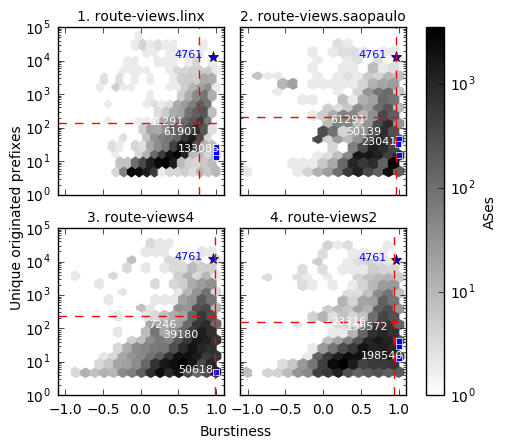

In [20]:
asn_attacker = '4761'

list_collectors = number_of_feeders[:4]

# Number of columns in the plot
col = 2
if len(list_collectors) % col != 0: # Odd
    row = int(len(list_collectors)/col) + 1
else: # Even
    row = int(len(list_collectors)/col)


fig, axes = plt.subplots(row, col, sharex=True, sharey=True) 
fig.subplots_adjust(hspace=0.2, wspace=0.1)

count = 0

for collector in list_collectors:
    
    print collector
    index_x = int(count/col)
    
    if count % col == 0:
        index_y = 0
    elif count % col == 1:
        index_y = 1
    else:
        index_y = 2
            
    ax = axes[index_x, index_y] 
    ax.set_title(str(count + 1) + '. ' + collector, fontsize=10) 

    if bivarite_distribution_dic[collector] != []:

        values = np.array(bivarite_distribution_dic[collector])
        x = values[:,0]
        y = values[:,1]
        
        print 'percentile_x', np.percentile(x, 95)
        print 'percentile_y', np.percentile(y, 95)

        hb = ax.hexbin(x, y, gridsize=15, yscale="log", norm=matplotlib.colors.LogNorm(), cmap="gist_yarg") # cmap="YlOrRd

        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([10**0, 10**5])

        if burstiness_annoucement_dic[collector][asn_attacker] != []:

            ax.text(burstiness_annoucement_dic[collector][asn_attacker][0]-0.5, burstiness_annoucement_dic[collector][asn_attacker][1], s=asn_attacker, fontsize=8, color='blue')
            ax.plot(burstiness_annoucement_dic[collector][asn_attacker][0], burstiness_annoucement_dic[collector][asn_attacker][1], marker="*", markersize=8, color="blue", markeredgecolor="black")
            print burstiness_annoucement_dic[collector][asn_attacker]
            
        times=0
        for top_ranked_asn in dic_of_tops_burstiness[collector][:3]:
            if burstiness_annoucement_dic[collector][top_ranked_asn] != []:
                ax.text(burstiness_annoucement_dic[collector][top_ranked_asn][0]-0.9 + times*0.2, burstiness_annoucement_dic[collector][top_ranked_asn][1]-times*50+100, s=top_ranked_asn, fontsize=8, color='white')
                #texts.append(ax.text(burstiness_annoucement_dic[collector][top_ranked_asn][0], burstiness_annoucement_dic[collector][top_ranked_asn][1], s=top_ranked_asn, fontsize=8, color='blue'))
                ax.plot(burstiness_annoucement_dic[collector][top_ranked_asn][0], burstiness_annoucement_dic[collector][top_ranked_asn][1], marker="s", markersize=5, color="blue", markeredgecolor="white")
                print top_ranked_asn, burstiness_annoucement_dic[collector][top_ranked_asn]
                times += 1
            
        # Dashed lines
        ax.axhline(np.percentile(y, 95), color='red', linewidth=1.0, linestyle='--') # 10**6
        ax.axvline(np.percentile(x, 95), color='red', linewidth=1.0, linestyle='--') # 0.90
     
    # Assign font size
    for label in ([ax.xaxis.label, ax.yaxis.label]):
        label.set_fontsize(10)

    # x axis
    for tl in ax.get_xticklabels():
        tl.set_fontsize(10)

    # y axis
    for tl in ax.get_yticklabels():
        tl.set_fontsize(10)
        
    # Change ticks space
    ax.tick_params(axis="both", which="major", pad=5)

    
    count += 1

# Colorbar
cb = fig.colorbar(hb, ax=axes.ravel().tolist(), fraction=0.05) # shrink=0.80
cb.ax.tick_params(labelsize=10) 
cb.ax.set_ylabel('ASes', rotation=90)
            
fig.text(0.41, 0.05, 'Burstiness', va="center", rotation="horizontal", fontsize=10)
fig.text(0.03, 0.5, 'Unique originated prefixes', va="center", rotation="vertical", fontsize=10)

size = 5 # 20
fig.set_size_inches(w=size, h=0.95*size) # size/1.618

plt.show()

## Remaining collectors

route-views.eqix
percentile_x 0.997072761542
percentile_y 131.85
[0.96366422140648256, 10938]
route-views6
percentile_x 0.740291760382
percentile_y 109.0
[0.7841843116613495, 564]
route-views.isc
percentile_x 0.989724227991
percentile_y 253.0
[0.96773671432983122, 12064]
route-views3
percentile_x 0.993409180905
percentile_y 171.0
[0.96024520378631129, 9617]
route-views.sydney
percentile_x 0.986795468331
percentile_y 142.0
[0.95063373296159148, 3595]
route-views.jinx
percentile_x 0.978132718349
percentile_y 80.0
[0.60537177893746719, 671]
route-views.telxatl
percentile_x 0.995283076627
percentile_y 196.0
[0.96336200258308324, 6929]
route-views.nwax
percentile_x 0.986549817659
percentile_y 231.0
[0.97198276446811804, 7028]
route-views.wide
percentile_x 0.992874610091
percentile_y 119.65
[0.71404376068692776, 2927]
route-views.perth
percentile_x 0.674166296927
percentile_y 36.5
route-views.kixp
percentile_x 0.690975648742
percentile_y 244.65
route-views.soxrs
percentile_x 0.938177186738
p

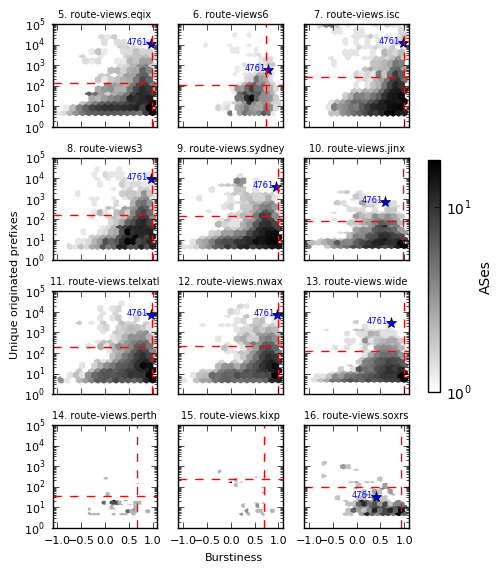

In [21]:
asn_attacker = '4761'

list_collectors = number_of_feeders[4:]

# Number of columns in the plot
col = 3
if len(list_collectors) % col != 0: # Odd
    row = int(len(list_collectors)/col) + 1
else: # Even
    row = int(len(list_collectors)/col)


fig, axes = plt.subplots(row, col, sharex=True, sharey=True) 
fig.subplots_adjust(hspace=0.3, wspace=0.2)

count = 0

for collector in list_collectors:
    
    print collector
    index_x = int(count/col)
    
    if count % col == 0:
        index_y = 0
    elif count % col == 1:
        index_y = 1
    else:
        index_y = 2
            
    ax = axes[index_x, index_y] 
    ax.set_title(str(count + 5) + '. ' + collector, fontsize=7) 

    if bivarite_distribution_dic[collector] != []:

        values = np.array(bivarite_distribution_dic[collector])
        # print type(values), values.shape
        # print values
        x = values[:,0]
        y = values[:,1]
        
        print 'percentile_x', np.percentile(x, 95)
        print 'percentile_y', np.percentile(y, 95)

        # ax.plot(x, y, linestyle="None", marker="o", mfc="None", markeredgecolor="black", label="Data")
        hb = ax.hexbin(x, y, gridsize=15, yscale="log", norm=matplotlib.colors.LogNorm(), cmap="gist_yarg") # cmap="YlOrRd

        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([10**0, 10**5])

        if burstiness_annoucement_dic[collector][asn_attacker] != []:

            ax.text(burstiness_annoucement_dic[collector][asn_attacker][0]-0.5, burstiness_annoucement_dic[collector][asn_attacker][1], s=asn_attacker, fontsize=6, color='blue')
            ax.plot(burstiness_annoucement_dic[collector][asn_attacker][0], burstiness_annoucement_dic[collector][asn_attacker][1], marker="*", markersize=8, color="blue", markeredgecolor="black")
            print burstiness_annoucement_dic[collector][asn_attacker]
            
        ax.axhline(np.percentile(y, 95), color='red', linewidth=1.0, linestyle='--') # 10**6
        ax.axvline(np.percentile(x, 95), color='red', linewidth=1.0, linestyle='--') # 0.90
     
    # Assign font size
    for label in ([ax.xaxis.label, ax.yaxis.label]):
        label.set_fontsize(8)

    # x axis
    for tl in ax.get_xticklabels():
        tl.set_fontsize(8)

    # y axis
    for tl in ax.get_yticklabels():
        tl.set_fontsize(8)

    # Change ticks space
    ax.tick_params(axis="both", which="major", pad=5)

    
    count += 1
    
# Colorbar
cb = fig.colorbar(hb, ax=axes.ravel().tolist(), fraction=0.03) # shrink=0.80
cb.ax.tick_params(labelsize=10) 
cb.ax.set_ylabel('ASes', rotation=90)
    
fig.text(0.43, 0.08, 'Burstiness', va="center", rotation="horizontal", fontsize=8)
fig.text(0.04, 0.5, 'Unique originated prefixes', va="center", rotation="vertical", fontsize=8)

size = 5 # 20
fig.set_size_inches(w=size, h=1.3*size) # size/1.618


plt.show()